In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Activation,Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.metrics import classification_report

- When we are working with custom image data we need to store the data in folders in a particular way as well.
- All the images have to be correctly numbered.
- We need to create 2 folders namely train and test.
- Inisde train and test we need to divide the images according to their categories.

- Unfortunately we cannot read all the data at once as it is gigabytes of data. Soo we need to use keras.preprocessing to create batches of images .
- If we create image datasets with slight transformations and random fluctuations it will create for a stronger model.

#### Image Data Generator

- Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!
- **rotation_range**: It will randomly rotate images in a certain range. We shouldn't give very large rotations to the images.
- **width_shift_range**: Shift the pic width by a max of n% in the x direction.(0-1)
- **height_shift_range**: Shift the pic height by a max of n% in the y direction.(0-1)
- **rescale**: Rescale the image by normalzing it.
- **shear_range**: Shear means cutting away part of the image/cropping(max of n%)
- **zoom_range**: Zoom in by n% max.(0-1)
- **horizontal_flip**: Flips the image horizontally.
- **fill_mode**: Fill in missing pixels with the nearest filled value.

- We can directly view at the generated image by calling image_gen.random_transform(img_name).


- The Dropout layer randomly turns of n%(0-1) of neurons to avoid overfitting.
- A good starting point for batch size is 16 , and the batch size is situation based.

In [3]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [4]:
# width,height,channels
# taking almost the average of hieght and width of all images.
image_shape = (150,150,3)

In [5]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=cat , 1=dog
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [7]:
batch_size = 16

# We have resized the image here while making the batches.
# class mode is binary as we have only cats and dogs.
train_image_gen = image_gen.flow_from_directory('CATS_DOGS/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [8]:
test_image_gen = image_gen.flow_from_directory('CATS_DOGS/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [9]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [10]:
results = model.fit_generator(train_image_gen,epochs=100,
                              steps_per_epoch=300,
                              validation_data=test_image_gen,
                             validation_steps=20)

Epoch 1/100
300/300 [==============================] - 60s 201ms/step - loss: 0.6936 - accuracy: 0.5194 - val_loss: 0.7139 - val_accuracy: 0.5656
Epoch 2/100
300/300 [==============================] - 62s 206ms/step - loss: 0.6806 - accuracy: 0.5800 - val_loss: 0.6312 - val_accuracy: 0.5781
Epoch 3/100
300/300 [==============================] - 63s 210ms/step - loss: 0.6668 - accuracy: 0.5973 - val_loss: 0.6020 - val_accuracy: 0.6438
Epoch 4/100
300/300 [==============================] - 60s 201ms/step - loss: 0.6669 - accuracy: 0.5969 - val_loss: 0.6987 - val_accuracy: 0.6531
Epoch 5/100
300/300 [==============================] - 64s 212ms/step - loss: 0.6602 - accuracy: 0.6070 - val_loss: 0.5518 - val_accuracy: 0.6438
Epoch 6/100
300/300 [==============================] - 63s 211ms/step - loss: 0.6519 - accuracy: 0.6273 - val_loss: 0.5572 - val_accuracy: 0.6719
Epoch 7/100
300/300 [==============================] - 61s 204ms/step - loss: 0.6318 - accuracy: 0.6519 - val_loss: 0.5915 -

Epoch 57/100
300/300 [==============================] - 61s 205ms/step - loss: 0.3688 - accuracy: 0.8410 - val_loss: 0.2228 - val_accuracy: 0.8594
Epoch 58/100
300/300 [==============================] - 61s 202ms/step - loss: 0.3746 - accuracy: 0.8431 - val_loss: 0.3157 - val_accuracy: 0.8656
Epoch 59/100
300/300 [==============================] - 61s 202ms/step - loss: 0.3891 - accuracy: 0.8293 - val_loss: 0.1737 - val_accuracy: 0.8032
Epoch 60/100
300/300 [==============================] - 61s 204ms/step - loss: 0.3625 - accuracy: 0.8413 - val_loss: 0.8079 - val_accuracy: 0.8156
Epoch 61/100
300/300 [==============================] - 62s 205ms/step - loss: 0.3768 - accuracy: 0.8384 - val_loss: 0.7632 - val_accuracy: 0.8281
Epoch 62/100
300/300 [==============================] - 61s 204ms/step - loss: 0.3684 - accuracy: 0.8377 - val_loss: 0.3083 - val_accuracy: 0.8313
Epoch 63/100
300/300 [==============================] - 61s 203ms/step - loss: 0.3594 - accuracy: 0.8402 - val_loss: 0

In [11]:
results.history['accuracy']

[0.519375,
 0.58004594,
 0.59729165,
 0.596875,
 0.6069714,
 0.6272917,
 0.651875,
 0.6639583,
 0.6720833,
 0.676875,
 0.6870833,
 0.7071593,
 0.6925,
 0.71822166,
 0.71208334,
 0.72,
 0.71979165,
 0.7391667,
 0.7447297,
 0.7497917,
 0.74645835,
 0.7575,
 0.759375,
 0.75474846,
 0.7614277,
 0.760625,
 0.7775,
 0.7675,
 0.7726988,
 0.7841667,
 0.78020835,
 0.79375,
 0.7810417,
 0.7920833,
 0.7939887,
 0.81083333,
 0.804375,
 0.8031726,
 0.7991667,
 0.81089544,
 0.81125,
 0.80916667,
 0.8072917,
 0.82,
 0.8027083,
 0.818125,
 0.82404506,
 0.8296806,
 0.8233333,
 0.82104164,
 0.82395834,
 0.8283333,
 0.83166665,
 0.82028806,
 0.836875,
 0.82958335,
 0.8410417,
 0.843125,
 0.8292632,
 0.84125,
 0.8384471,
 0.83770835,
 0.84020835,
 0.85041666,
 0.83520836,
 0.83979166,
 0.8478397,
 0.8510417,
 0.84291667,
 0.84729165,
 0.8399082,
 0.84270835,
 0.8535417,
 0.84658736,
 0.84291667,
 0.84979165,
 0.850625,
 0.85869336,
 0.851875,
 0.8541667,
 0.85138804,
 0.850625,
 0.85479164,
 0.85625,
 0.8

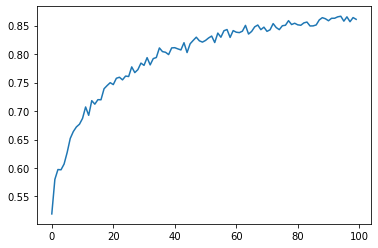

In [12]:
plt.plot(results.history['accuracy'])

### Predicting output for a test image.

In [13]:
dog_file = 'CATS_DOGS/train/Dog/2.jpg'

dog_img = image.load_img(dog_file, target_size=(150, 150))

dog_img = image.img_to_array(dog_img)

dog_img = np.expand_dims(dog_img, axis=0) #We need to expand the dimensions before predicting.
dog_img = dog_img/255

In [14]:
prediction_prob = model.predict(dog_img)

In [15]:
print(f'Probability that image is a dog is: {prediction_prob} ')

Probability that image is a dog is: [[0.7312466]] 


In [19]:
#plot_model(model,to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot',format='svg'))